In [ ]:
!pip install kaggle

# **Setup Kaggle API and Download Dataset**

In [ ]:
import os
from google.colab import files
import shutil

os.makedirs("/content/datasets", exist_ok=True)
os.makedirs("/root/.kaggle", exist_ok=True)

uploaded = files.upload()

shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)
print("kaggle.json uploaded and configured successfully.")

Saving kaggle.json to kaggle.json
kaggle.json uploaded and configured successfully.


In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
  0% 0.00/121M [00:00<?, ?B/s]
100% 121M/121M [00:00<00:00, 1.66GB/s]


In [ ]:

!unzip -q face-expression-recognition-dataset.zip
!ls -la

total 123428
drwxr-xr-x 1 root root      4096 Jan  6 00:47 .
drwxr-xr-x 1 root root      4096 Jan  6 00:40 ..
drwxr-xr-x 4 root root      4096 Dec  9 14:41 .config
drwxr-xr-x 2 root root      4096 Jan  6 00:45 datasets
-rw-r--r-- 1 root root 126358582 Oct 17  2019 face-expression-recognition-dataset.zip
drwxr-xr-x 5 root root      4096 Jan  6 00:47 images
drwxr-xr-x 1 root root      4096 Dec  9 14:42 sample_data


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import gradio as gr

# 1. **Dataset Preparation**

In [ ]:
dataset_path = '/content/images'

train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

if not os.path.exists(train_dir):
    print(f"Training directory not found at {train_dir}")
    print("Please ensure the dataset has been downloaded and the path is correct")
    exit()

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['happy', 'sad']
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['happy', 'sad']
)

print(f"Number of Training Samples: {train_generator.samples}")
print(f"Number of Validation Samples: {validation_generator.samples}")
print(f"Class Indices: {train_generator.class_indices}")

Found 12102 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.
Number of Training Samples: 12102
Number of Validation Samples: 2964
Class Indices: {'happy': 0, 'sad': 1}


In [ ]:
dataset_path = '/content/images'
subdirs = os.listdir(dataset_path)
print("Main directories:", subdirs)

for subdir in subdirs:
    full_path = os.path.join(dataset_path, subdir)
    if os.path.isdir(full_path):
        print(f"\n{subdir} contains:")
        emotion_classes = os.listdir(full_path)
        print(emotion_classes)

Main directories: ['validation', 'train', 'images']

validation contains:
['happy', 'sad', 'angry', 'fear', 'disgust', 'surprise', 'neutral']

train contains:
['happy', 'sad', 'angry', 'fear', 'disgust', 'surprise', 'neutral']

images contains:
['validation', 'train']


#**Count Images Per Class in Each Split**

In [ ]:
def count_images_per_class(directory):
    counts = {}

    # The global emotion_classes is already defined and available
    # No need for the conditional assignment, just use the global one
    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path) and os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
        else:
            counts[emotion] = 0
    return counts


train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(validation_dir)


print("Training set counts:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")

print("\nTotal training images:", sum(train_counts.values()))

print("\nValidation set counts:")
for emotion, count in val_counts.items():
    print(f"{emotion}: {count}")

print("\nTotal validation images:", sum(val_counts.values()))

Training set counts:
validation: 0
train: 0

Total training images: 0

Validation set counts:
validation: 0
train: 0

Total validation images: 0


# **Display Sample Images from Each Class**

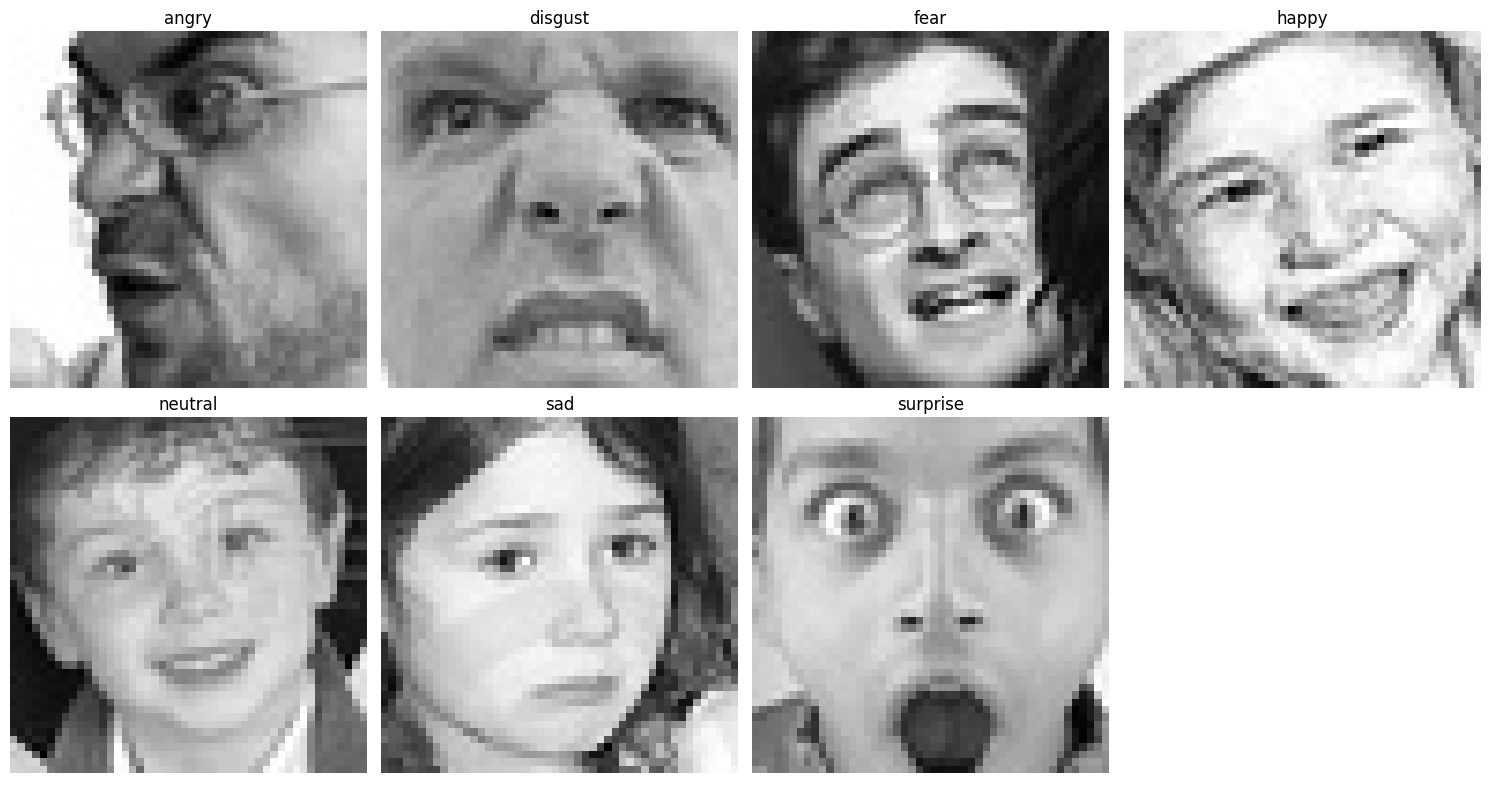

In [ ]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

# Redefine emotion_classes correctly to list subdirectories within train_dir
# This assumes train_dir contains directories like 'happy', 'sad', etc.
emotion_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
emotion_classes.sort() # Sort for consistent display

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

# Iterate through all emotion classes or up to 7 if there are more subplots (like 8)
display_classes = emotion_classes[:7]

for i, emotion in enumerate(display_classes):
    emotion_path = os.path.join(train_dir, emotion)
    image_files = os.listdir(emotion_path)
    if image_files: # Ensure there are images in the directory
        sample_image = random.choice(image_files)
        img_path = os.path.join(emotion_path, sample_image)

        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(emotion)
        axes[i].axis('off')
    else:
        # If no images, just turn off the axis for this subplot
        axes[i].axis('off')
        axes[i].set_title(f"{emotion} (No Images)")

# Turn off any remaining unused subplots (e.g., if less than 7 classes or if 7 classes and 8 plots)
for j in range(len(display_classes), len(axes)):
    axes[j].axis('off')


plt.tight_layout()
plt.show()

#  **Histogram Equalization for Contrast Enhancement**

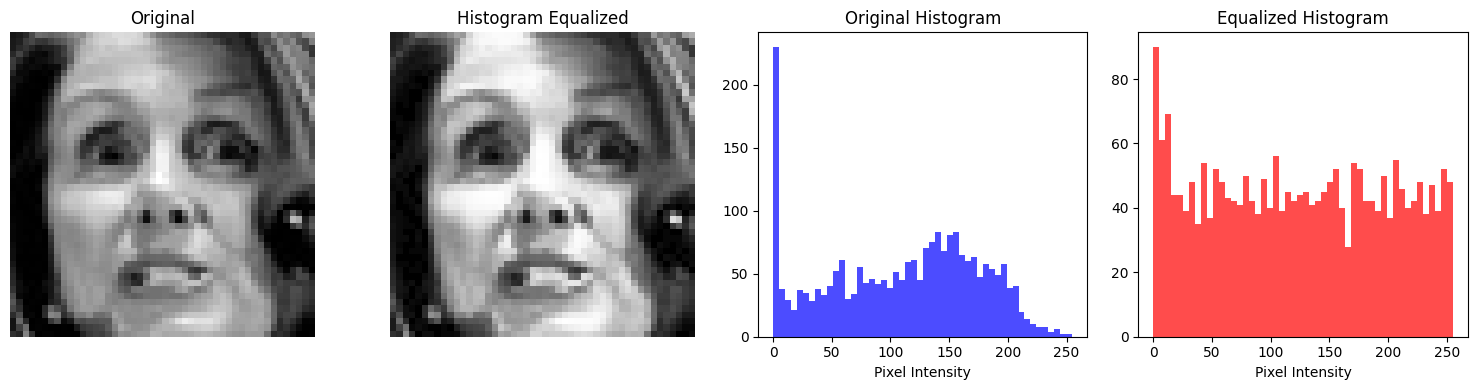

In [ ]:
import cv2

def apply_histogram_equalization(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    equalized = cv2.equalizeHist(img)
    return img, equalized

sample_emotion = emotion_classes[0]
sample_path = os.path.join(train_dir, sample_emotion)
sample_file = os.listdir(sample_path)[0]
img_path = os.path.join(sample_path, sample_file)

original, equalized = apply_histogram_equalization(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(equalized, cmap='gray')
axes[1].set_title('Histogram Equalized')
axes[1].axis('off')

axes[2].hist(original.flatten(), bins=50, alpha=0.7, color='blue')
axes[2].set_title('Original Histogram')
axes[2].set_xlabel('Pixel Intensity')

axes[3].hist(equalized.flatten(), bins=50, alpha=0.7, color='red')
axes[3].set_title('Equalized Histogram')
axes[3].set_xlabel('Pixel Intensity')

plt.tight_layout()
plt.show()

 # **Gaussian Blur for Noise Reduction**

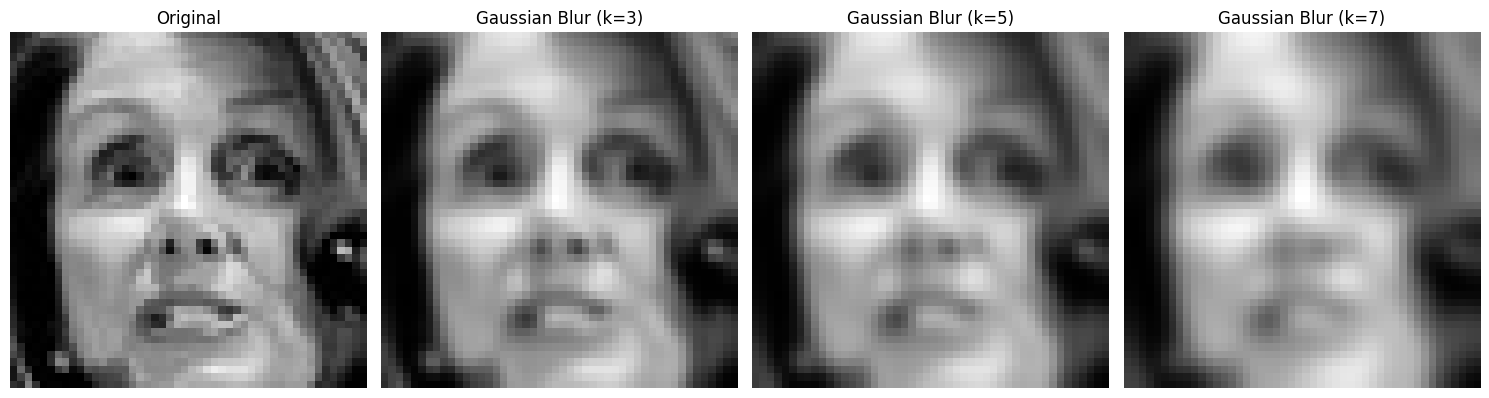

In [ ]:
def apply_gaussian_blur(image_path, kernel_sizes=[3, 5, 7]):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_images = []

    for kernel_size in kernel_sizes:
        blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
        blurred_images.append(blurred)

    return img, blurred_images

original, blurred_list = apply_gaussian_blur(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

for i, (blurred, kernel_size) in enumerate(zip(blurred_list, [3, 5, 7])):
    axes[i+1].imshow(blurred, cmap='gray')
    axes[i+1].set_title(f'Gaussian Blur (k={kernel_size})')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


# **Edge Detection with Canny Filter**

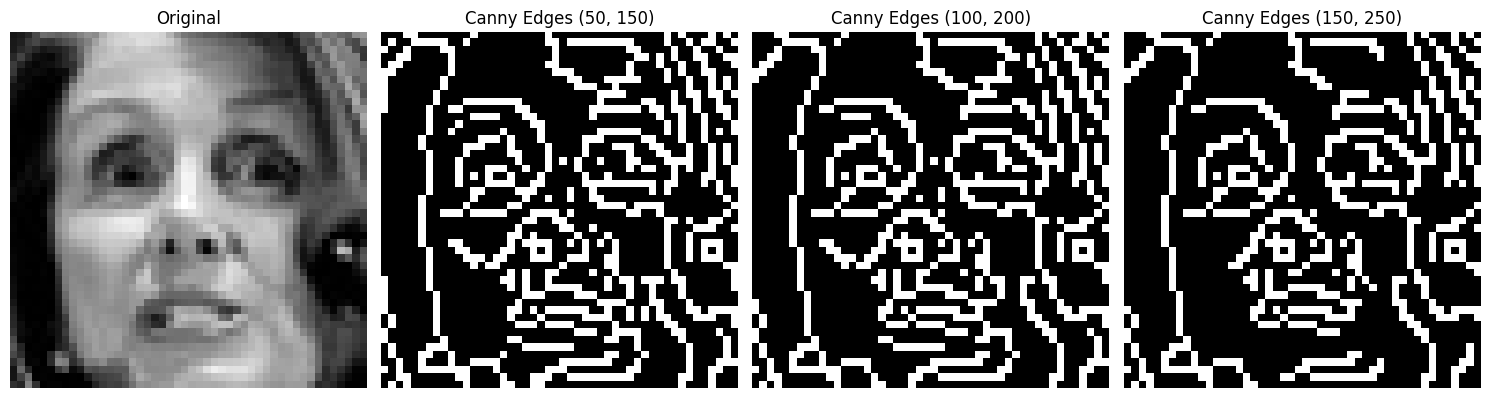

In [ ]:
def apply_canny_edge_detection(image_path, thresholds=[(50, 150), (100, 200), (150, 250)]):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edge_images = []

    for low_thresh, high_thresh in thresholds:
        edges = cv2.Canny(img, low_thresh, high_thresh)
        edge_images.append(edges)

    return img, edge_images

original, edges_list = apply_canny_edge_detection(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

thresholds = [(50, 150), (100, 200), (150, 250)]
for i, (edges, thresh) in enumerate(zip(edges_list, thresholds)):
    axes[i+1].imshow(edges, cmap='gray')
    axes[i+1].set_title(f'Canny Edges {thresh}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


 # **Morphologica**l **Operations**

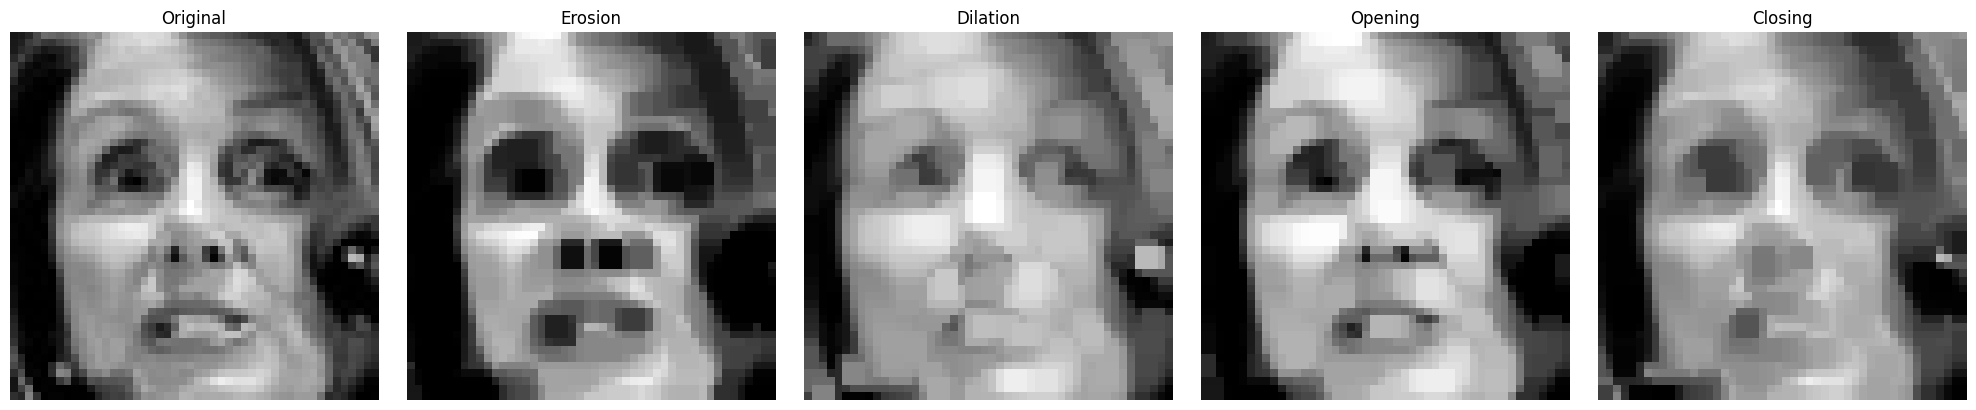

In [ ]:
def apply_morphological_operations(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    kernel = np.ones((3,3), np.uint8)

    erosion = cv2.erode(img, kernel, iterations=1)
    dilation = cv2.dilate(img, kernel, iterations=1)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    return img, erosion, dilation, opening, closing

results = apply_morphological_operations(img_path)
titles = ['Original', 'Erosion', 'Dilation', 'Opening', 'Closing']

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, (result, title) in enumerate(zip(results, titles)):
    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


 # **Adaptive Thresholding**

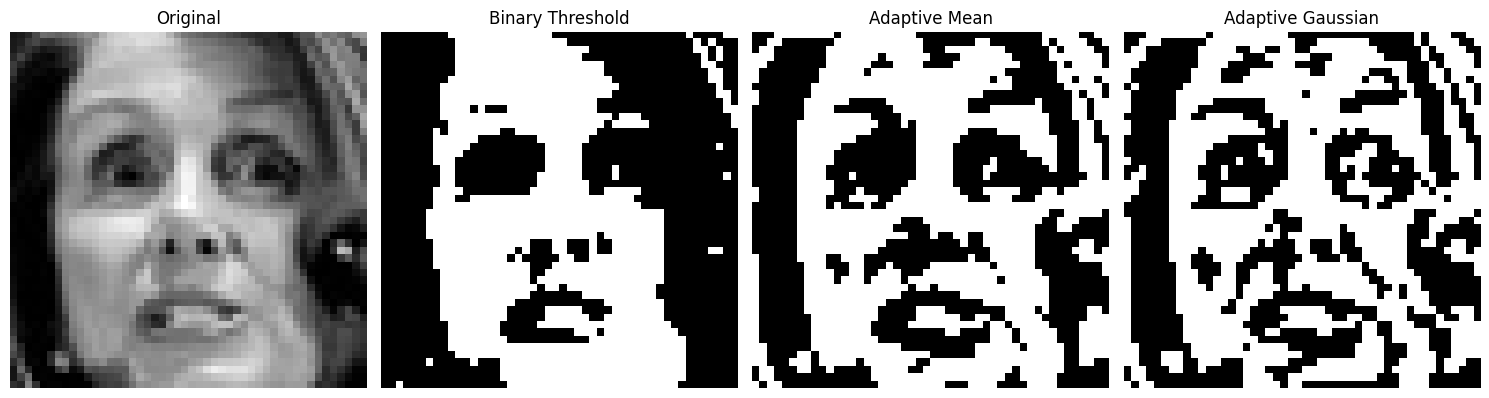

In [ ]:
def apply_adaptive_thresholding(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    ret, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    adaptive_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    adaptive_gaussian = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return img, binary, adaptive_mean, adaptive_gaussian

original, binary, adaptive_mean, adaptive_gaussian = apply_adaptive_thresholding(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
images = [original, binary, adaptive_mean, adaptive_gaussian]
titles = ['Original', 'Binary Threshold', 'Adaptive Mean', 'Adaptive Gaussian']

for i, (img, title) in enumerate(zip(images, titles)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


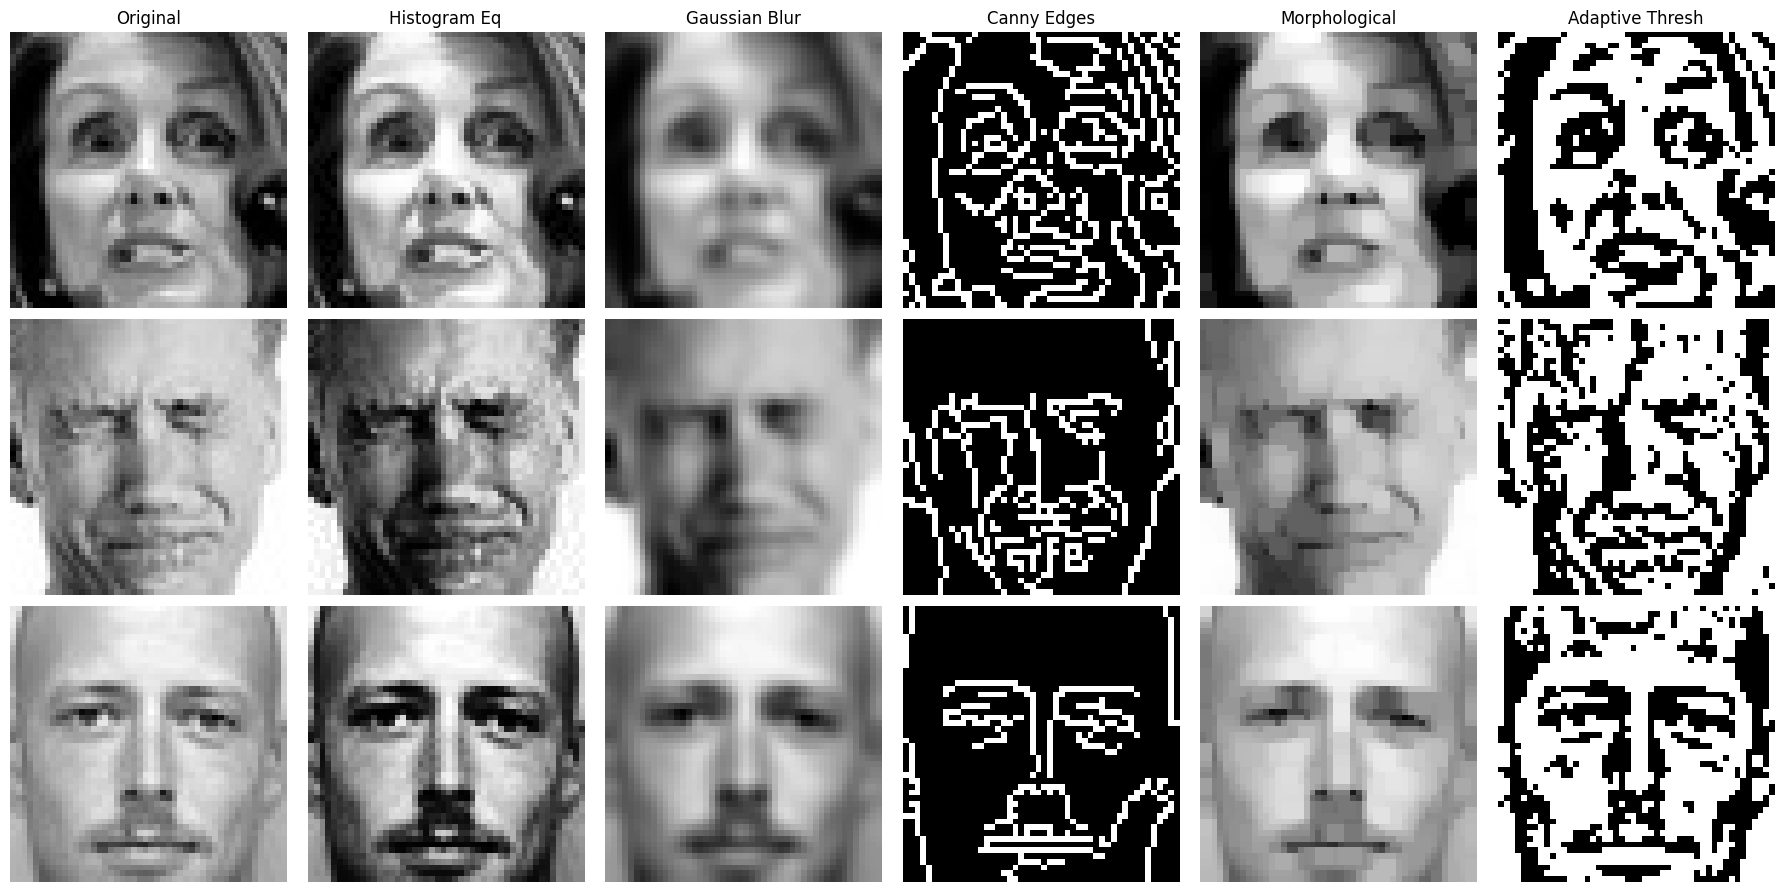

In [ ]:
sample_images = []
for emotion in emotion_classes[:3]:
    emotion_path = os.path.join(train_dir, emotion)
    img_file = os.listdir(emotion_path)[0]
    img_path = os.path.join(emotion_path, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    sample_images.append((img, emotion))

fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for row, (img, emotion) in enumerate(sample_images):
    equalized = cv2.equalizeHist(img)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(img, 100, 200)
    kernel = np.ones((3,3), np.uint8)
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    processed_images = [img, equalized, blurred, edges, morphed, adaptive]
    titles = ['Original', 'Histogram Eq', 'Gaussian Blur', 'Canny Edges', 'Morphological', 'Adaptive Thresh']

    for col, (processed, title) in enumerate(zip(processed_images, titles)):
        axes[row, col].imshow(processed, cmap='gray')
        if row == 0:
            axes[row, col].set_title(title)
        if col == 0:
            axes[row, col].set_ylabel(emotion, rotation=0, ha='right')
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


# **Class Distribution**

In [ ]:
emotions = list(train_counts.keys())
counts = list(train_counts.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(emotions, counts, color='skyblue', alpha=0.7)
plt.title('Distribution of Images per Emotion Class (Training Set)')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


/tmp/ipython-input-90192157.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


# **Check for Class Imbalance**

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/content/images'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'valid')
test_dir = os.path.join(dataset_path, 'test')

emotion_classes = os.listdir(train_dir)
emotion_classes.sort()

def count_images_per_class(directory):
    counts = {}
    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
        else:
            counts[emotion] = 0
    return counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

max_count = max(train_counts.values())
min_count = min(train_counts.values())
imbalance_ratio = max_count / min_count

print(f"Maximum images in a class: {max_count}")
print(f"Minimum images in a class: {min_count}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2.0:
    print("Significant class imbalance detected. Data augmentation recommended.")
else:
    print("Class distribution is relatively balanced.")

if imbalance_ratio > 2.0:
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        fill_mode='nearest',
        preprocessing_function=lambda x: cv2.equalizeHist(x.astype(np.uint8)) if len(x.shape) == 2 else x
    )
    print("Enhanced data augmentation with histogram equalization configured")
else:
    datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=lambda x: cv2.equalizeHist((x*255).astype(np.uint8))/255.0 if len(x.shape) == 2 else x
    )
    print("Basic preprocessing with histogram equalization configured")

Maximum images in a class: 7164
Minimum images in a class: 436
Imbalance ratio: 16.43
Significant class imbalance detected. Data augmentation recommended.
Enhanced data augmentation with histogram equalization configured


# **Analyze Image Properties**

In [ ]:
import random
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def process_image_batch(directory, num_samples=100):
    processed_data = {
        'original': [],
        'histogram_eq': [],
        'gaussian_blur': [],
        'processed_count': 0
    }

    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        image_files = os.listdir(emotion_path)

        sample_size = min(num_samples // len(emotion_classes), len(image_files))
        selected_files = random.sample(image_files, sample_size)

        for img_file in selected_files:
            img_path = os.path.join(emotion_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))

            hist_eq = cv2.equalizeHist(img)
            gaussian = cv2.GaussianBlur(img, (3, 3), 0)

            processed_data['original'].append(img)
            processed_data['histogram_eq'].append(hist_eq)
            processed_data['gaussian_blur'].append(gaussian)
            processed_data['processed_count'] += 1

    return processed_data

processed_batch = process_image_batch(train_dir)
print(f"Processed {processed_batch['processed_count']} images with multiple techniques")

original_mean = np.mean([img.mean() for img in processed_batch['original']])
hist_eq_mean = np.mean([img.mean() for img in processed_batch['histogram_eq']])
gaussian_mean = np.mean([img.mean() for img in processed_batch['gaussian_blur']])

print(f"Average pixel intensity - Original: {original_mean:.2f}")
print(f"Average pixel intensity - Histogram Equalized: {hist_eq_mean:.2f}")
print(f"Average pixel intensity - Gaussian Blurred: {gaussian_mean:.2f}")

Processed 98 images with multiple techniques
Average pixel intensity - Original: 127.95
Average pixel intensity - Histogram Equalized: 127.67
Average pixel intensity - Gaussian Blurred: 128.00


In [ ]:
max_count = max(train_counts.values())
min_count = min(train_counts.values())
imbalance_ratio = max_count / min_count

print(f"Maximum images in a class: {max_count}")
print(f"Minimum images in a class: {min_count}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2.0:
    print("Significant class imbalance detected. Data augmentation recommended.")
else:
    print("Class distribution is relatively balanced.")


Maximum images in a class: 7164
Minimum images in a class: 436
Imbalance ratio: 16.43
Significant class imbalance detected. Data augmentation recommended.


In [ ]:
def load_sample_images(directory, num_samples=5):
    sample_data = []

    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        image_files = os.listdir(emotion_path)

        samples = random.sample(image_files, min(num_samples, len(image_files)))

        for img_file in samples:
            img_path = os.path.join(emotion_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            sample_data.append({
                'emotion': emotion,
                'image': img,
                'shape': img.shape,
                'size': img.size
            })

    return sample_data

sample_data = load_sample_images(train_dir)
print(f"Loaded {len(sample_data)} sample images")


Loaded 35 sample images


In [ ]:
from collections import Counter

shapes = [data['shape'] for data in sample_data]
sizes = [data['size'] for data in sample_data]

shape_counter = Counter(shapes)
print("Image shapes distribution:")
for shape, count in shape_counter.items():
    print(f"{shape}: {count} images")

print(f"\nAverage image size: {np.mean(sizes):.0f} pixels")
print(f"Image size range: {min(sizes)} - {max(sizes)} pixels")

sample_img = sample_data[0]['image']
print(f"\nSample image details:")
print(f"Shape: {sample_img.shape}")
print(f"Data type: {sample_img.dtype}")
print(f"Min pixel value: {sample_img.min()}")
print(f"Max pixel value: {sample_img.max()}")

Image shapes distribution:
(48, 48): 35 images

Average image size: 2304 pixels
Image size range: 2304 - 2304 pixels

Sample image details:
Shape: (48, 48)
Data type: uint8
Min pixel value: 5
Max pixel value: 128


# **Data Augmentation**

In [ ]:
if imbalance_ratio > 2.0:
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        fill_mode='nearest'
    )
    print("Data augmentation configured")
else:
    datagen = ImageDataGenerator(rescale=1./255)
    print("Basic data normalization configured")


Data augmentation configured


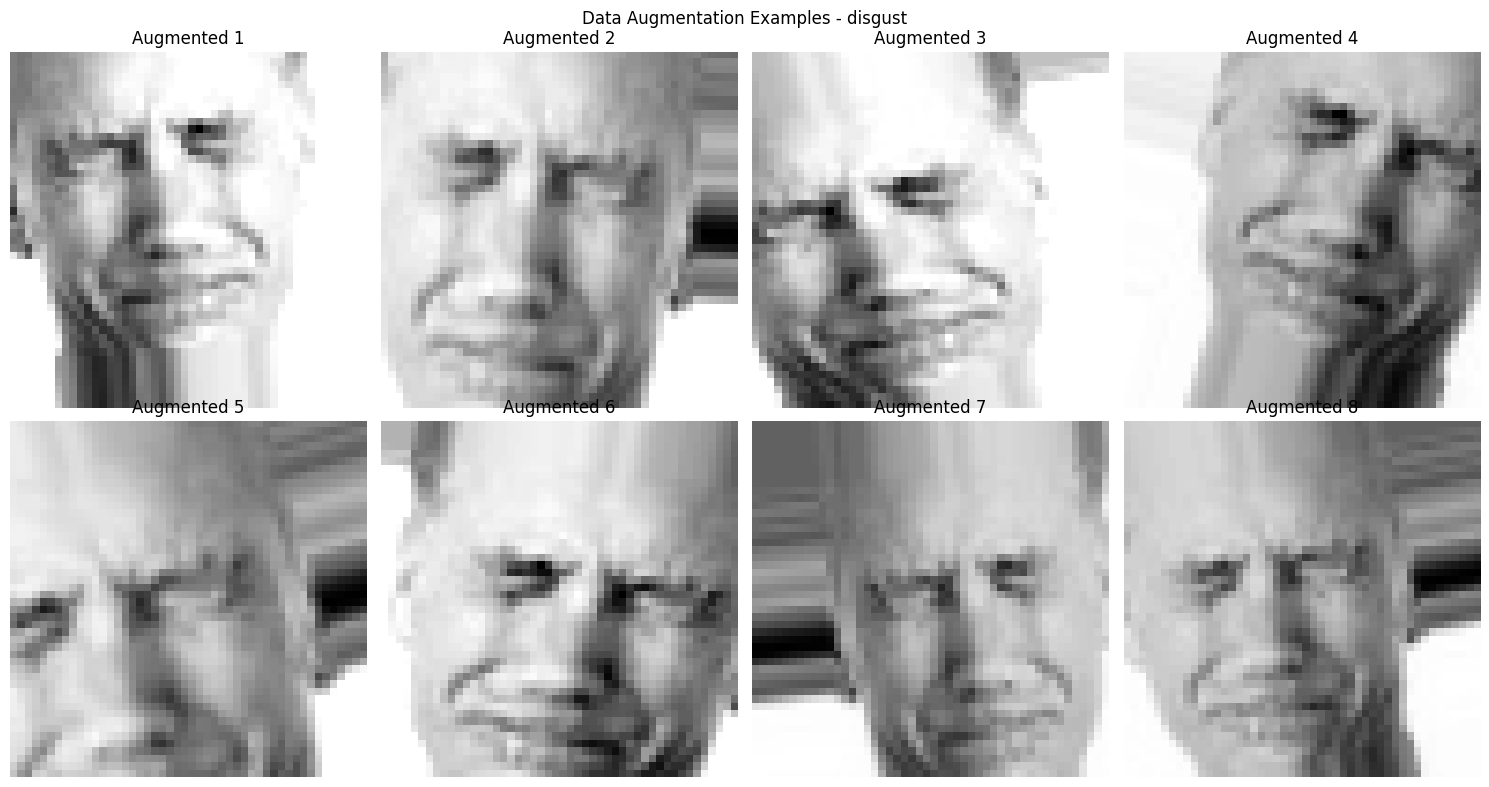

In [ ]:
if imbalance_ratio > 2.0:
    sample_emotion = emotion_classes[1]
    sample_path = os.path.join(train_dir, sample_emotion)
    sample_files = os.listdir(sample_path)

    img = Image.open(os.path.join(sample_path, sample_files[0]))
    img_array = np.array(img).reshape((1,) + img.size + (1,))

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        axes[i].imshow(batch[0].squeeze(), cmap='gray')
        axes[i].set_title(f'Augmented {i+1}')
        axes[i].axis('off')
        i += 1
        if i >= 8:
            break

    plt.suptitle(f'Data Augmentation Examples - {sample_emotion}')
    plt.tight_layout()
    plt.show()


# **MobileNet**

In [ ]:
binary_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

binary_val_datagen = ImageDataGenerator(rescale=1./255)

binary_train = binary_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    classes=['happy', 'sad'],
    shuffle=True
)

binary_val = binary_val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    classes=['happy', 'sad'],
    shuffle=False
)


Found 12102 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNet

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

base_mobilenet = MobileNet(weights='imagenet', include_top=False,
                           input_shape=(img_height, img_width, 3))
for layer in base_mobilenet.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_mobilenet.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

mobilenetv1_binary = Model(inputs=base_mobilenet.input, outputs=output)
mobilenetv1_binary.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mobilenetv1_history = mobilenetv1_binary.fit(
    binary_train,
    epochs=2,
    validation_data=binary_val,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
379/379 ━━━━━━━━━━━━━━━━━━━━ 170s 413ms/step - accuracy: 0.6342 - loss: 0.6489 - val_accuracy: 0.7456 - val_loss: 0.5024 - learning_rate: 1.0000e-04
Epoch 2/2
379/379 ━━━━━━━━━━━━━━━━━━━━ 135s 356ms/step - accuracy: 0.7384 - loss: 0.5257 - val_accuracy: 0.7611 - val_loss: 0.4705 - learning_rate: 1.0000e-04


MOBILENET V1 - EVALUATION
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step
Validation Accuracy: 0.7611
Precision: 0.8048
Recall: 0.4996
F1-Score: 0.6165


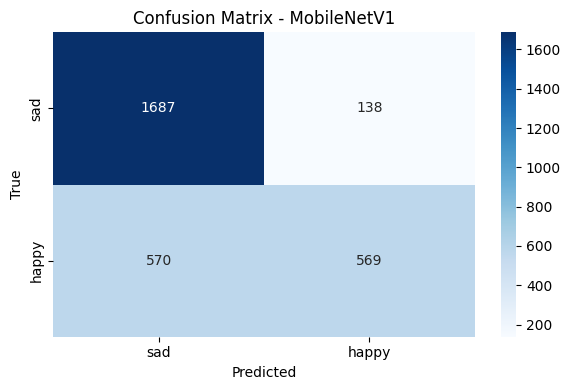


Classification Report:
              precision    recall  f1-score   support

         sad       0.75      0.92      0.83      1825
       happy       0.80      0.50      0.62      1139

    accuracy                           0.76      2964
   macro avg       0.78      0.71      0.72      2964
weighted avg       0.77      0.76      0.75      2964



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

print("="*60)
print("MOBILENET V1 - EVALUATION")
print("="*60)

binary_val.reset()
y_prob = mobilenetv1_binary.predict(binary_val, verbose=1)
y_pred = (y_prob.ravel() >= 0.5).astype(int)
y_true = binary_val.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["sad", "happy"],
    yticklabels=["sad", "happy"]
)
plt.title("Confusion Matrix - MobileNetV1")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["sad", "happy"]))


In [ ]:
from google.colab import files

mobilenetv1_path = "mobilenetv1_happy_sad.h5"
mobilenetv1_binary.save(mobilenetv1_path)
print(f"Saved: {mobilenetv1_path}")
files.download(mobilenetv1_path)


Saved: mobilenetv1_happy_sad.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **MobileNetV3Small**

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small

base_mobilenetv3 = MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3),
    include_preprocessing=False
)
for layer in base_mobilenetv3.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_mobilenetv3.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

mobilenetv3_binary = Model(inputs=base_mobilenetv3.input, outputs=output)
mobilenetv3_binary.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mobilenetv3_history = mobilenetv3_binary.fit(
    binary_train,
    epochs=10,
    validation_data=binary_val,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 163s 399ms/step - accuracy: 0.6262 - loss: 0.6422 - val_accuracy: 0.7203 - val_loss: 0.5420 - learning_rate: 1.0000e-04
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 132s 349ms/step - accuracy: 0.7108 - loss: 0.5665 - val_accuracy: 0.7456 - val_loss: 0.5198 - learning_rate: 1.0000e-04
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 131s 347ms/step - accuracy: 0.7368 - loss: 0.5375 - val_accuracy: 0.7588 - val_loss: 0.4991 - learning_rate: 1.0000e-04
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 133s 349ms/step - accuracy: 0.7418 - loss: 0.5231 - val_accuracy: 0.7689 - val_loss: 0.4796 - learning_rate: 1.0000e-04
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 132s 348ms/step - accuracy: 0.7657 - loss: 0.5009 - val_accuracy: 0.7686 - val_loss: 0.4863 - learning_rate: 1.0000e-04
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 132s 349ms/step - accuracy: 0.7583 - loss: 0.4962 - val_accuracy: 0.7723 - val_loss: 0.4759 - learning_rate: 1.

MOBILENET V3Small - EVALUATION
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step
Validation Accuracy: 0.7901
Precision: 0.7522
Recall: 0.6769
F1-Score: 0.7126


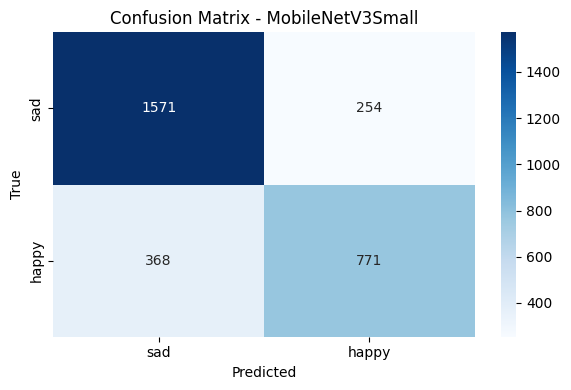


Classification Report:
              precision    recall  f1-score   support

         sad       0.81      0.86      0.83      1825
       happy       0.75      0.68      0.71      1139

    accuracy                           0.79      2964
   macro avg       0.78      0.77      0.77      2964
weighted avg       0.79      0.79      0.79      2964



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

print("="*60)
print("MOBILENET V3Small - EVALUATION")
print("="*60)


binary_val.reset()
y_prob = mobilenetv3_binary.predict(binary_val, verbose=1)
y_pred = (y_prob.ravel() >= 0.5).astype(int)
y_true = binary_val.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['sad', 'happy'],
            yticklabels=['sad', 'happy'])
plt.title('Confusion Matrix - MobileNetV3Small')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['sad', 'happy']))


In [ ]:
from google.colab import files

mobilenetv3_path = "mobilenetv3small_happy_sad.h5"
mobilenetv3_binary.save(mobilenetv3_path)
print(f"Saved: {mobilenetv3_path}")
files.download(mobilenetv3_path)


Saved: mobilenetv3small_happy_sad.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **EfficientNetB0**

EFFICIENTNET B0 MODEL SUMMARY


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Training EfficientNetB0...
Epoch 1/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 183s 431ms/step - accuracy: 0.5883 - loss: 0.6792 - val_accuracy: 0.6157 - val_loss: 0.6664 - learning_rate: 1.0000e-04
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 139s 367ms/step - accuracy: 0.5931 - loss: 0.6779 - val_accuracy: 0.6157 - val_loss: 0.6674 - learning_rate: 1.0000e-04
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 138s 364ms/step - accuracy: 0.5892 - loss: 0.6784 - val_accuracy: 0.6157 - val_loss: 0.6702 - learning_rate: 1.0000e-04
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 139s 366ms/step - accuracy: 0.5952 - loss: 0.6772 - val_accuracy: 0.6157 - val_loss: 0.6710 - learning_rate: 1.0000e-04
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 141s 364ms/step - accuracy: 0.6022 - loss: 0.6749 - val_accuracy: 0.6157 - val_loss: 0.6668 - learning_rate: 1.0000e-04
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 138s 365ms/step - accuracy: 0.5953 - loss: 0.6770 - val_accuracy: 0.6157 - val_loss: 0.6693 - learning_rate: 1.0000e-04
Epoch 7/10
3

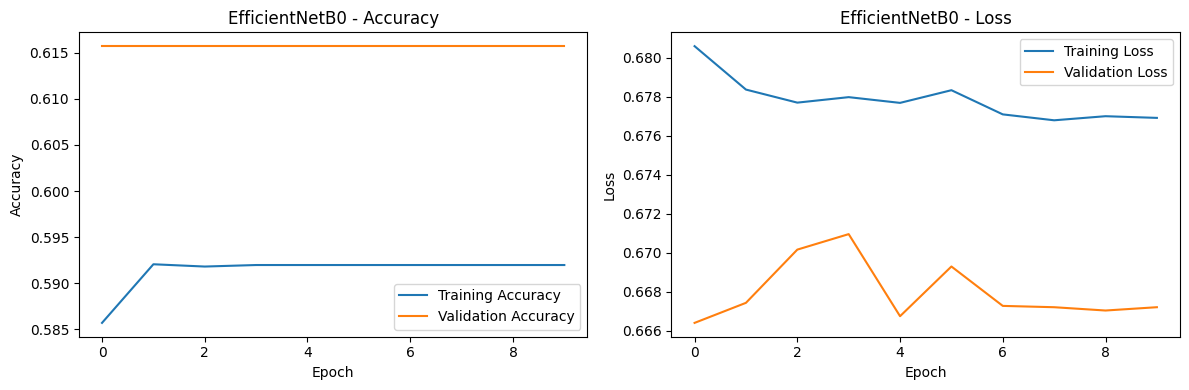


EFFICIENTNET B0 - EVALUATION
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step
Validation Accuracy: 0.6157
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


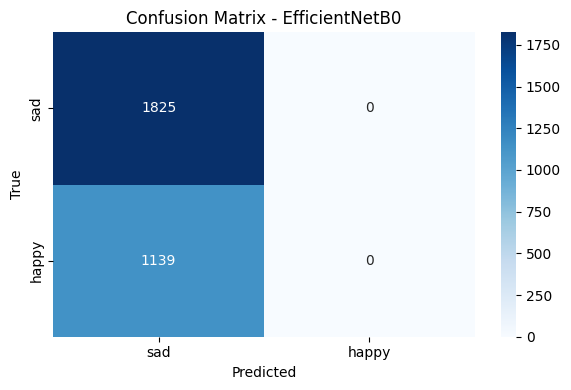


Classification Report:
              precision    recall  f1-score   support

         sad       0.62      1.00      0.76      1825
       happy       0.00      0.00      0.00      1139

    accuracy                           0.62      2964
   macro avg       0.31      0.50      0.38      2964
weighted avg       0.38      0.62      0.47      2964



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np


base_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base layers
for layer in base_efficientnet.layers:
    layer.trainable = False

x = base_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

efficientnet_model = Model(inputs=base_efficientnet.input, outputs=output)

efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("="*60)
print("EFFICIENTNET B0 MODEL SUMMARY")
print("="*60)
efficientnet_model.summary()

earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

print("\nTraining EfficientNetB0...")
efficientnet_history = efficientnet_model.fit(
    binary_train,
    epochs=10,
    validation_data=binary_val,
    callbacks=[earlystopping, reducelr],
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(efficientnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_history.history['loss'], label='Training Loss')
plt.plot(efficientnet_history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
print("\n" + "="*60)
print("EFFICIENTNET B0 - EVALUATION")
print("="*60)

binary_val.reset()
y_prob = efficientnet_model.predict(binary_val, verbose=1)
y_pred = (y_prob.ravel() >= 0.5).astype(int)
y_true = binary_val.classes

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['sad', 'happy'],
            yticklabels=['sad', 'happy'])
plt.title('Confusion Matrix - EfficientNetB0')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['sad', 'happy']))


# **MobileNetV2**

In [42]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 172s 417ms/step - accuracy: 0.6529 - loss: 0.6197 - val_accuracy: 0.7456 - val_loss: 0.5148 - learning_rate: 1.0000e-04
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 138s 365ms/step - accuracy: 0.7115 - loss: 0.5559 - val_accuracy: 0.7625 - val_loss: 0.4955 - learning_rate: 1.0000e-04
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 136s 359ms/step - accuracy: 0.7269 - loss: 0.5387 - val_accuracy: 0.7648 - val_loss: 0.4861 - learning_rate: 1.0000e-04
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 136s 358ms/step - accuracy: 0.7279 - loss: 0.5310 - val_accuracy: 0.7743 - val_loss: 0.4774 - learning_rate: 1.0000e-04
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 136s 357ms/step - accuracy: 0.7455 - loss: 0.5140 - val_accuracy: 0.7777 - val_loss: 0.4687 - learning_rate: 1.0000e-04
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 135s 356ms/step - accuracy: 0.7454 - loss: 0.5116 - val_accuracy: 0.7743 - val_loss: 0.4749 - learning_rate: 1.0000e-04
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 

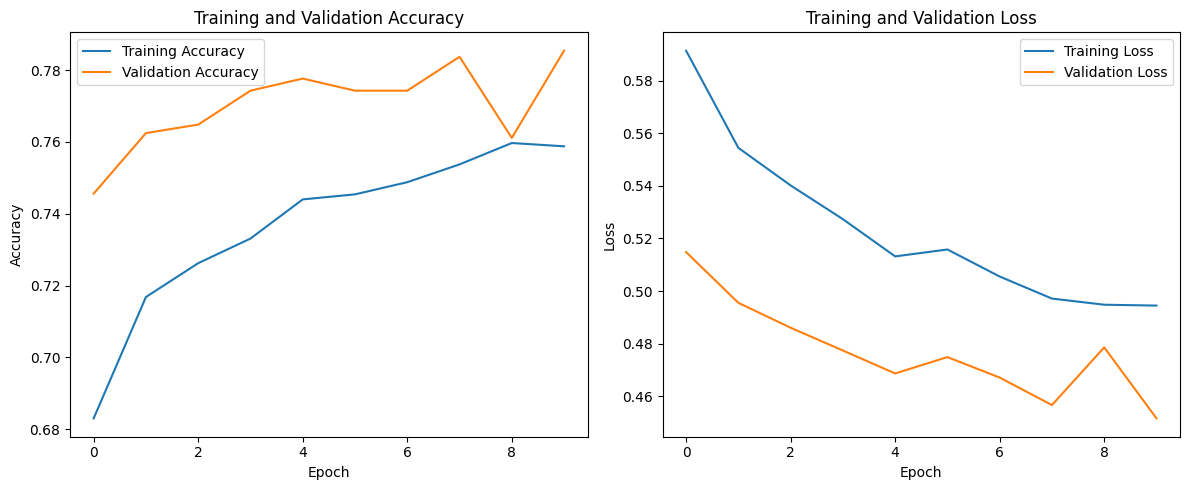

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7934 - loss: 0.4370
Loss on Validation Data: 0.4516
Accuracy on Validation Data: 0.7854


In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

loss, accuracy = model.evaluate(validation_generator)
print(f"Loss on Validation Data: {loss:.4f}")
print(f"Accuracy on Validation Data: {accuracy:.4f}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step


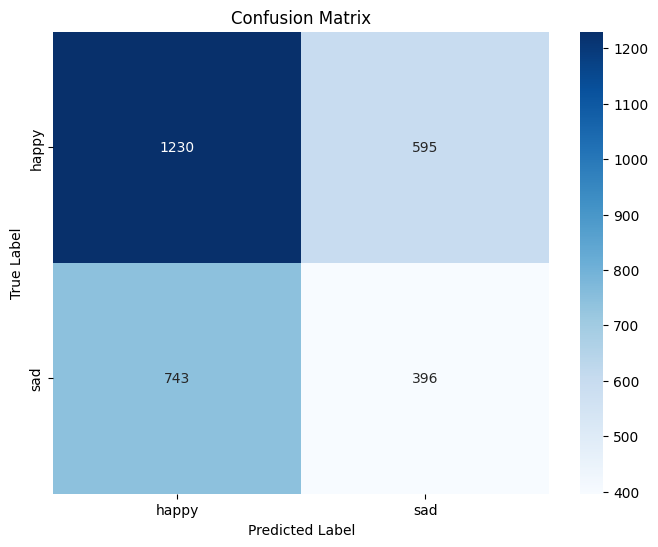

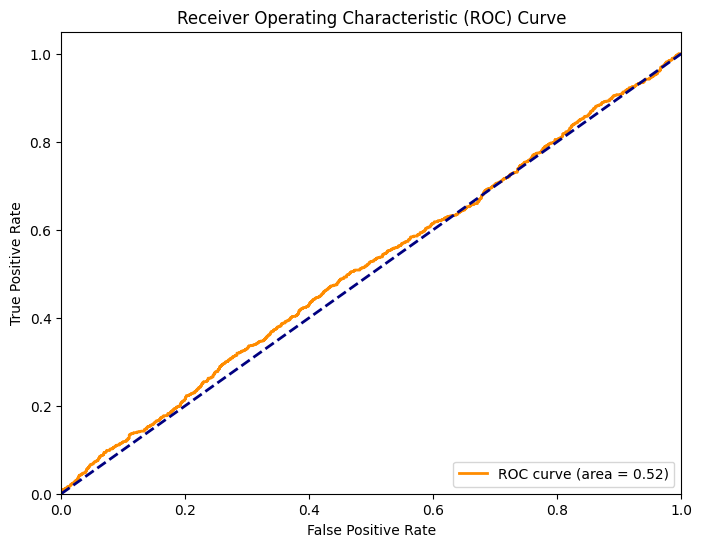

In [45]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns


validation_generator.reset()
predictions = model.predict(validation_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = validation_generator.classes


cm = confusion_matrix(y_true, y_pred)


report = classification_report(y_true, y_pred, target_names=['happy', 'sad'], output_dict=True)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['happy', 'sad'], yticklabels=['happy', 'sad'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


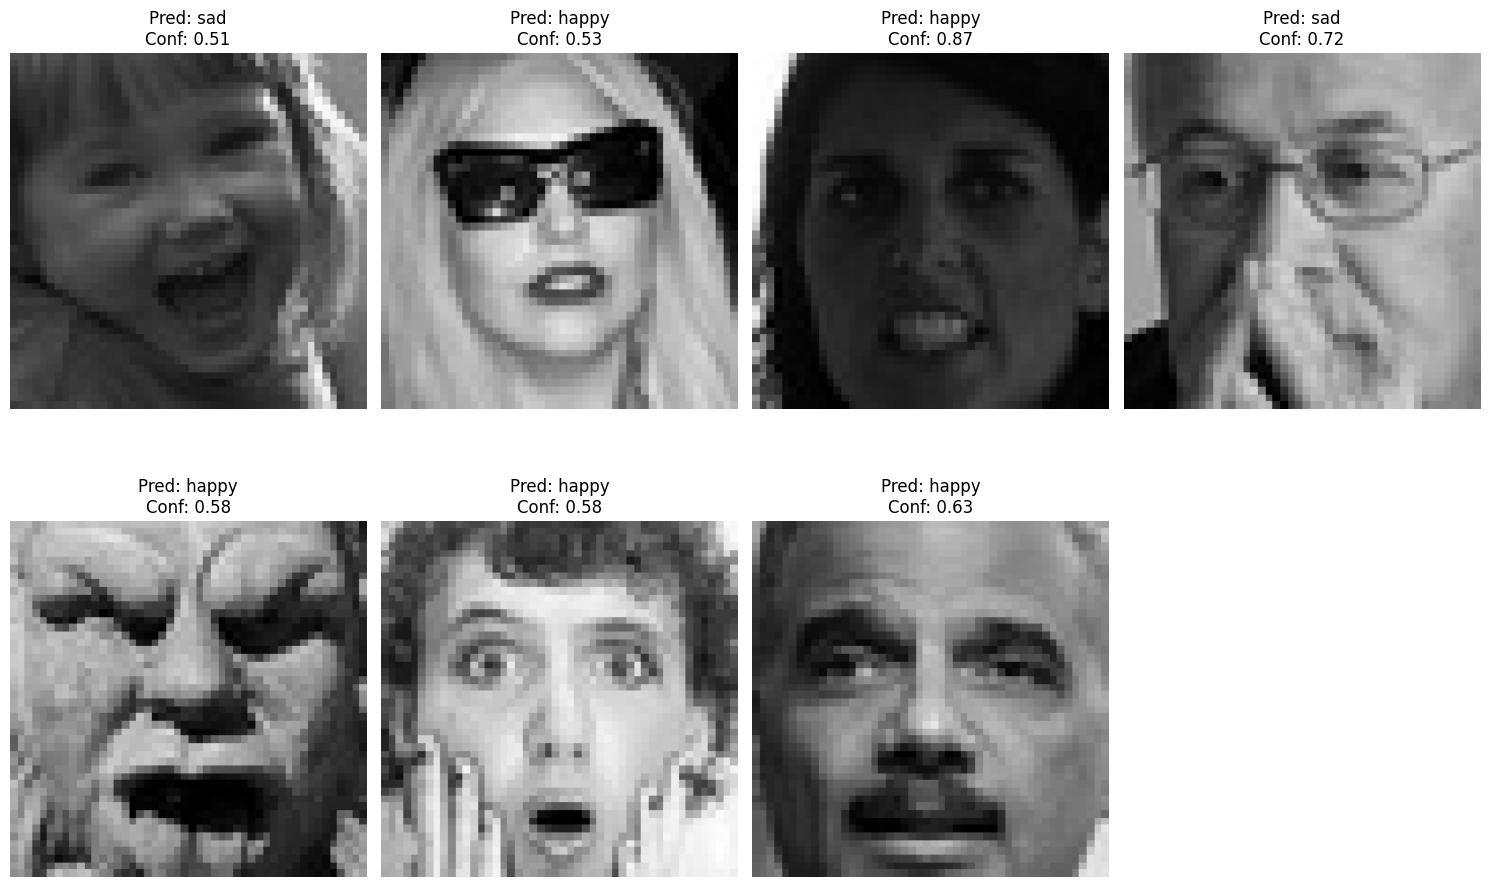

In [46]:
import random
import numpy as np
from tensorflow.keras.preprocessing import image

model_class_names = list(train_generator.class_indices.keys())


validation_classes = [d for d in os.listdir(validation_dir) if os.path.isdir(os.path.join(validation_dir, d))]

sample_image_paths = []

for class_name in validation_classes:
    class_path = os.path.join(validation_dir, class_name)
    images_in_class = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images_in_class:
        sample_image_paths.append(os.path.join(class_path, random.choice(images_in_class)))
    if len(sample_image_paths) == 7:
        break


plt.figure(figsize=(15, 10))

for i, img_path in enumerate(sample_image_paths):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale

    prediction = model.predict(img_array)[0][0]
    predicted_class_index = (prediction > 0.5).astype(int)
    predicted_label = model_class_names[predicted_class_index]
    confidence = prediction if predicted_class_index == 1 else (1 - prediction)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {predicted_label}\nConf: {confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

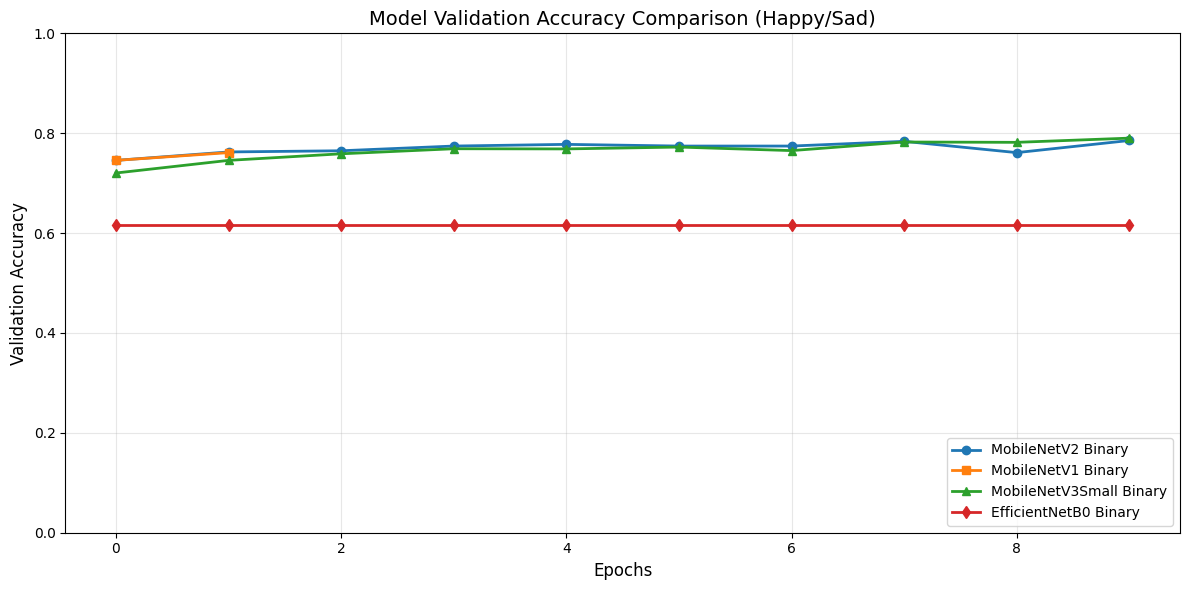


FINAL VALIDATION ACCURACIES
MobileNetV2 Binary:  0.7854
MobileNetV1 Binary:  0.7611
MobileNetV3 Binary:  0.7901
EfficientNetB0 Binary:0.6157


In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


plt.plot(history.history['val_accuracy'],
         label='MobileNetV2 Binary', linewidth=2, marker='o')
plt.plot(mobilenetv1_history.history['val_accuracy'],
         label='MobileNetV1 Binary', linewidth=2, marker='s')
plt.plot(mobilenetv3_history.history['val_accuracy'],
         label='MobileNetV3Small Binary', linewidth=2, marker='^')
plt.plot(efficientnet_history.history['val_accuracy'],
         label='EfficientNetB0 Binary', linewidth=2, marker='d')

plt.title('Model Validation Accuracy Comparison (Happy/Sad)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])
plt.tight_layout()
plt.show()


print("\n" + "="*60)
print("FINAL VALIDATION ACCURACIES")
print("="*60)

print(f"MobileNetV2 Binary:  {history.history['val_accuracy'][-1]:.4f}")
print(f"MobileNetV1 Binary:  {mobilenetv1_history.history['val_accuracy'][-1]:.4f}")
print(f"MobileNetV3 Binary:  {mobilenetv3_history.history['val_accuracy'][-1]:.4f}")
print(f"EfficientNetB0 Binary:{efficientnet_history.history['val_accuracy'][-1]:.4f}")

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("="*60)
print("FINETUNED MOBILENETV1 CONFIGURATION")
print("="*60)

# Load base model (MobileNetV1)
base_mobilenet = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Fine-tuning: Unfreeze last 30 layers for better feature learning
for layer in base_mobilenet.layers[:-30]:
    layer.trainable = False
for layer in base_mobilenet.layers[-30:]:
    layer.trainable = True

print(f"Total layers: {len(base_mobilenet.layers)}")
print(f"Trainable layers (last 30): {[layer.name for layer in base_mobilenet.layers[-30:]]}")

# Enhanced custom head with regularization
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
finetuned_mobilenetv1 = Model(inputs=base_mobilenet.input, outputs=output)

finetuned_mobilenetv1.compile(
    optimizer=Adam(learning_rate=0.000005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

finetuned_mobilenetv1.summary()

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=4,
    min_lr=0.0000001,  # 1e-7
    mode='max',
    verbose=1
)

# Train the fine-tuned model
print("\nTraining Fine-Tuned MobileNetV1...")
finetuned_history = finetuned_mobilenetv1.fit(
    binary_train,
    epochs=25,
    validation_data=binary_val,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


FINETUNED MOBILENETV1 CONFIGURATION
Total layers: 86
Trainable layers (last 30): ['conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu', 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu', 'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu', 'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu', 'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu']


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,525,825 (13.45 MB)

 Trainable params: 2,691,841 (10.27 MB)

 Non-trainable params: 833,984 (3.18 MB)


Training Fine-Tuned MobileNetV1...
Epoch 1/25
379/379 ━━━━━━━━━━━━━━━━━━━━ 173s 416ms/step - accuracy: 0.5201 - loss: 0.9623 - val_accuracy: 0.6468 - val_loss: 0.6475 - learning_rate: 5.0000e-06
Epoch 2/25
379/379 ━━━━━━━━━━━━━━━━━━━━ 144s 379ms/step - accuracy: 0.5680 - loss: 0.8365 - val_accuracy: 0.6903 - val_loss: 0.6087 - learning_rate: 5.0000e-06
Epoch 3/25
 25/379 ━━━━━━━━━━━━━━━━━━━━ 2:00 339ms/step - accuracy: 0.6275 - loss: 0.7679

### **Setup & Predictions**

FINETUNED MOBILENETV1 - EVALUATION
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step
Validation Accuracy: 0.8816
Precision: 0.8107
Recall: 0.9025
F1-Score: 0.8542


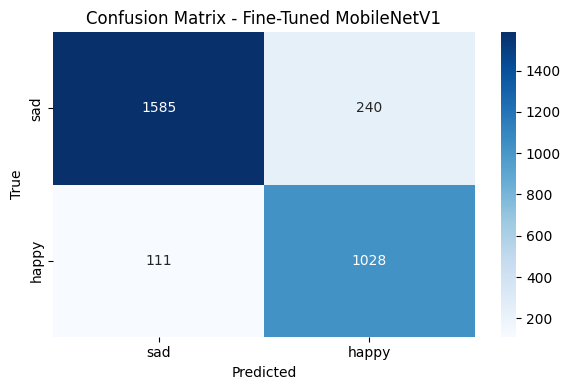


Classification Report:
              precision    recall  f1-score   support

         sad       0.93      0.87      0.90      1825
       happy       0.81      0.90      0.85      1139

    accuracy                           0.88      2964
   macro avg       0.87      0.89      0.88      2964
weighted avg       0.89      0.88      0.88      2964


Saved: mobilenetv1_finetuned_happy_sad.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

print("="*60)
print("FINETUNED MOBILENETV1 - EVALUATION")
print("="*60)

binary_val.reset()
y_prob = finetuned_mobilenetv1.predict(binary_val, verbose=1)
y_pred = (y_prob.ravel() >= 0.5).astype(int)
y_true = binary_val.classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['sad', 'happy'],
            yticklabels=['sad', 'happy'])
plt.title('Confusion Matrix - Fine-Tuned MobileNetV1')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['sad', 'happy']))

# Save model
from google.colab import files
finetuned_path = "mobilenetv1_finetuned_happy_sad.h5"
finetuned_mobilenetv1.save(finetuned_path)
print(f"\nSaved: {finetuned_path}")
files.download(finetuned_path)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)

print("="*60)
print("COMPREHENSIVE EVALUATION: FINE-TUNED MOBILENETV1")
print("="*60)

# Get predictions
binary_val.reset()
y_prob = finetuned_mobilenetv1.predict(binary_val, verbose=1)
y_pred = (y_prob.ravel() >= 0.5).astype(int)
y_true = binary_val.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


COMPREHENSIVE EVALUATION: FINE-TUNED MOBILENETV1
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step


### **Learning Curves (Accuracy)**

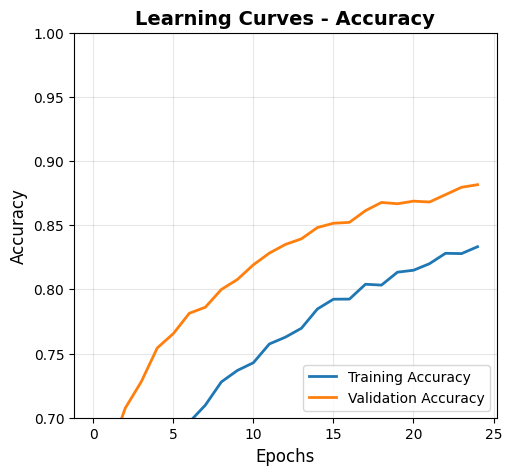

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(finetuned_history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(finetuned_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Learning Curves - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim([0.7, 1.0])
plt.show()


### **Loss Curves**

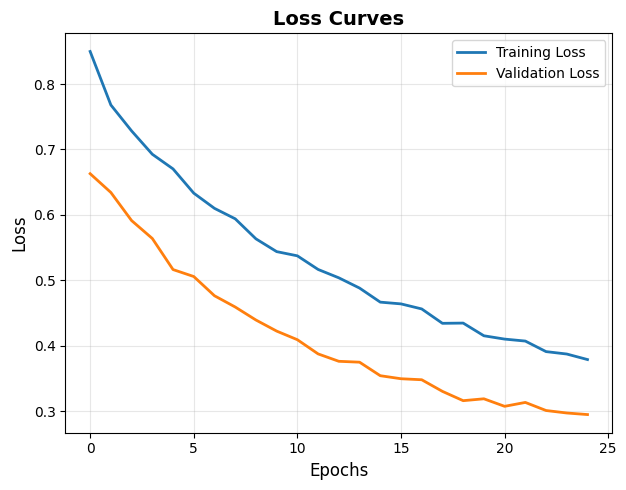

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(finetuned_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(finetuned_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### **Combined Training Curves**

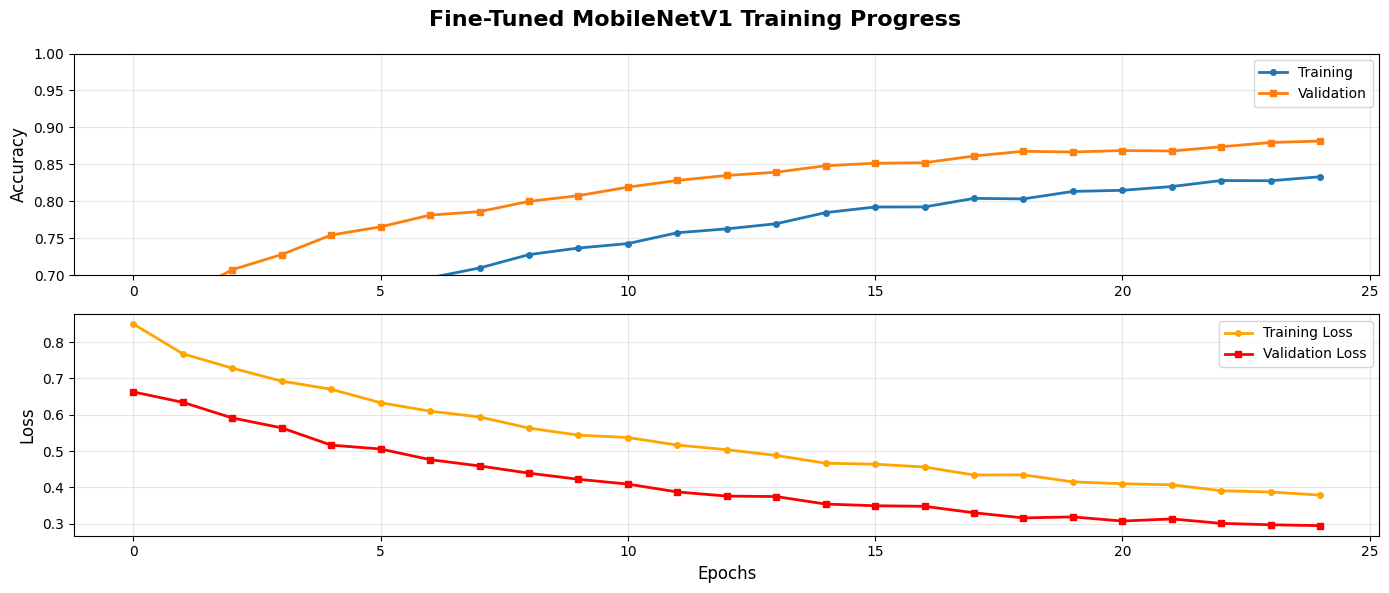

In [ ]:
plt.figure(figsize=(14, 6))
plt.suptitle('Fine-Tuned MobileNetV1 Training Progress', fontsize=16, fontweight='bold')

plt.subplot(2, 1, 1)
plt.plot(finetuned_history.history['accuracy'], label='Training', linewidth=2, marker='o', markersize=4)
plt.plot(finetuned_history.history['val_accuracy'], label='Validation', linewidth=2, marker='s', markersize=4)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.7, 1.0])

plt.subplot(2, 1, 2)
plt.plot(finetuned_history.history['loss'], label='Training Loss', linewidth=2, color='orange', marker='o', markersize=4)
plt.plot(finetuned_history.history['val_loss'], label='Validation Loss', linewidth=2, color='red', marker='s', markersize=4)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### **ROC Curve**

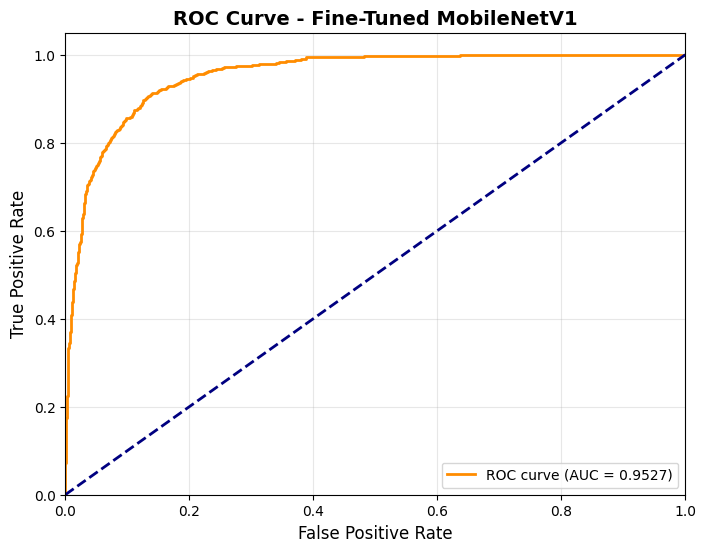

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Fine-Tuned MobileNetV1', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


 ### **Confusion Matrix**

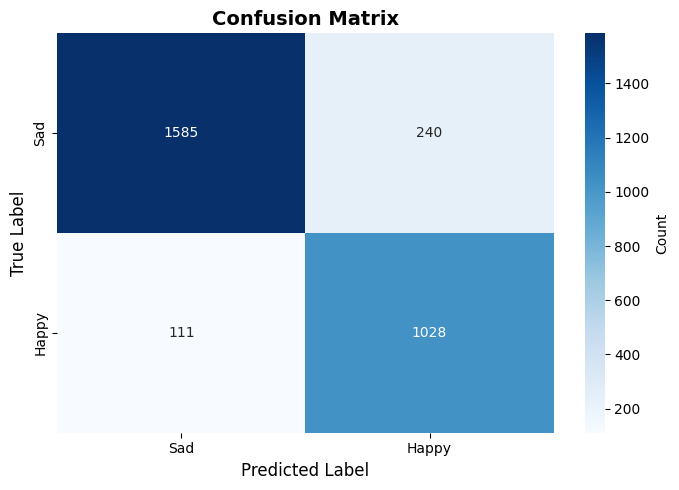

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Sad', 'Happy'],
            yticklabels=['Sad', 'Happy'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()


### **Comparative Bar Charts**

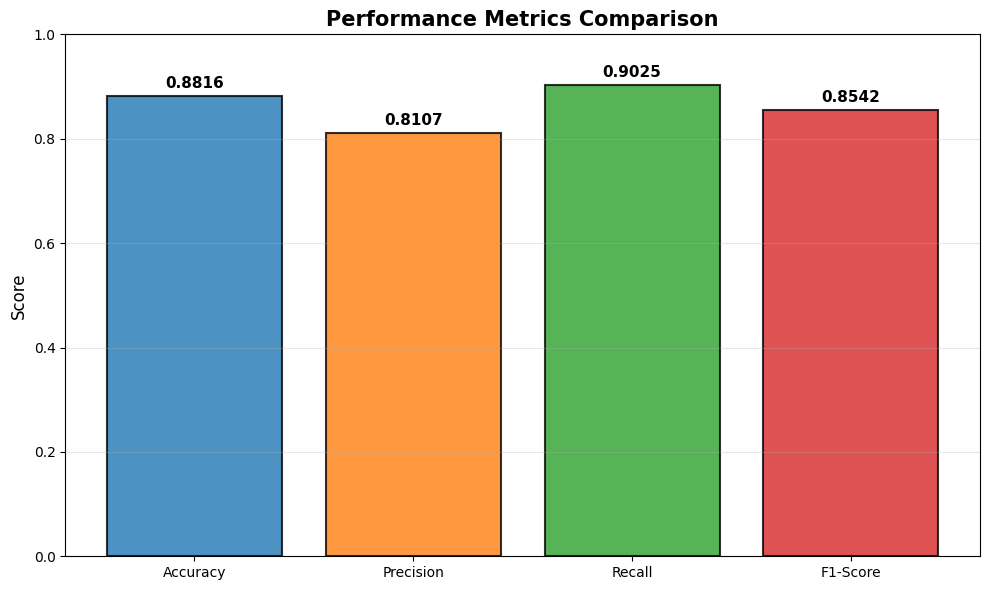

In [ ]:
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(),
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, metrics.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Performance Metrics Comparison', fontsize=15, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.ylim([0, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### **Detailed Metrics Summary**

In [ ]:
print("\n" + "="*60)
print("DETAILED METRICS SUMMARY")
print("="*60)
print(f"{'Accuracy:':<15} {accuracy:.4f}")
print(f"{'Precision:':<15} {precision:.4f}")
print(f"{'Recall:':<15} {recall:.4f}")
print(f"{'F1-Score:':<15} {f1:.4f}")
print(f"{'ROC-AUC:':<15} {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Sad', 'Happy']))



DETAILED METRICS SUMMARY
Accuracy:       0.8816
Precision:      0.8107
Recall:         0.9025
F1-Score:       0.8542
ROC-AUC:        0.5237

Classification Report:
              precision    recall  f1-score   support

         Sad       0.93      0.87      0.90      1825
       Happy       0.81      0.90      0.85      1139

    accuracy                           0.88      2964
   macro avg       0.87      0.89      0.88      2964
weighted avg       0.89      0.88      0.88      2964

